In [ ]:
import pandas as pd
import json

# Function to filter products belonging to both "Electronics" and "Headphones" categories
def is_headphones(data):
    categories = "Electronics" in data.get('category', []) and "Headphones" in data.get('category', [])
    return categories

# Function to read metadata from meta file
def read_metadata(file_path):
    metadata_dict = {}
    with open(file_path, 'r') as f:
        for line in f:
            try:
                data = json.loads(line)
                if is_headphones(data):
                    metadata_dict[data['asin']] = data
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
    return metadata_dict

# Function to extract reviews from review file
def extract_reviews(file_path, metadata_dict):
    reviews = []
    with open(file_path, 'r') as f:
        for line in f:
            try:
                data = json.loads(line)
                asin = data.get('asin')
                if asin in metadata_dict:
                    reviews.append(data)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
    return reviews

# Read metadata
metadata_dict = read_metadata('/kaggle/input/electronics/meta_Electronics.json')

# Extract reviews for headphones
headphones_reviews = extract_reviews('/kaggle/input/electronics/Electronics_5.json', metadata_dict)

# Convert reviews to DataFrame
reviews_df = pd.DataFrame(headphones_reviews)

# Convert metadata to DataFrame
metadata_df = pd.DataFrame(metadata_dict.values())

print(metadata_df)

In [ ]:
metadata_df.to_csv('headphones_metadata.csv', index=False, escapechar='\\')

In [ ]:
reviews_df.to_csv('headphones_reviews.csv', index=False, escapechar='\\')

In [ ]:
print(reviews_df)

In [ ]:
import pandas as pd

# Load the headphones reviews CSV file
reviews_df = pd.read_csv('/kaggle/input/after-extraction-files/headphones_reviews.csv')

# Report the total number of rows before preprocessing
total_rows = len(reviews_df)
print("Total number of rows before preprocessing:", total_rows)

# Handling missing values
reviews_df.dropna(inplace=True)

# Removing duplicates
reviews_df.drop_duplicates(inplace=True)

# Report the new total number of rows after preprocessing
new_total_rows = len(reviews_df)
print("Total number of rows after preprocessing:", new_total_rows)

# Save the preprocessed headphones reviews to a new CSV file
reviews_df.to_csv('preprocessed_headphones_reviews.csv', index=False)


In [ ]:
print(reviews_df)

In [ ]:
import pandas as pd

# Load the preprocessed headphones reviews CSV file
reviews_df = pd.read_csv('/kaggle/input/preprocessed-reviews/preprocessed_headphones_reviews.csv')

# a. Number of Reviews
num_reviews = len(reviews_df)

# b. Average Rating Score
avg_rating_score = reviews_df['overall'].mean()

# c. Number of Unique Products
num_unique_products = len(reviews_df['asin'].unique())

# d. Number of Good Rating (ratings >= 3)
num_good_ratings = len(reviews_df[reviews_df['overall'] >= 3])

# e. Number of Bad Ratings (ratings < 3)
num_bad_ratings = len(reviews_df[reviews_df['overall'] < 3])

# f. Number of Reviews corresponding to each Rating
reviews_per_rating = reviews_df['overall'].value_counts().sort_index()

# Print the descriptive statistics
print("Number of Reviews:", num_reviews)
print("Average Rating Score:", avg_rating_score)
print("Number of Unique Products:", num_unique_products)
print("Number of Good Ratings:", num_good_ratings)
print("Number of Bad Ratings:", num_bad_ratings)
print("\nNumber of Reviews corresponding to each Rating:")
print(reviews_per_rating)


In [ ]:
import spacy
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from bs4 import BeautifulSoup
import pandas as pd
import re

# Load the English language model in spaCy
nlp = spacy.load("en_core_web_sm")

# Load the preprocessed headphones reviews CSV file
reviews_df = pd.read_csv('/kaggle/input/preprocessed-reviews/preprocessed_headphones_reviews.csv')

# Define the acronyms and their expansions
acronyms = { 'ANC': 'Active Noise Cancellation',
             'BT': 'Bluetooth',
             'IEM': 'In-Ear Monitor',
             'OEM': 'Original Equipment Manufacturer',
             'DAC': 'Digital-to-Analog Converter',
             'AMP': 'Amplifier',
             'EQ': 'Equalizer',
             'DAP': 'Digital Audio Player',
             'LDAC': 'Lossless Digital Audio Codec',
             'AAC': 'Advanced Audio Coding',
             'aptX': 'Audio Codec developed by Qualcomm',
             'THD': 'Total Harmonic Distortion',
             'SPL': 'Sound Pressure Level',
             'RMS': 'Root Mean Square',
             'Hz': 'Hertz (frequency measurement)',
             'dB': 'Decibel (sound pressure level measurement)',
             'CVC': 'Clear Voice Capture (noise reduction technology)',
             'NC': 'Noise Cancelling',
             'L/R': 'Left/Right (channel designation)',
             'TRS': 'Tip-Ring-Sleeve (audio connector type)',
             'TRRS': 'Tip-Ring-Ring-Sleeve (audio connector type, commonly used for headphones with built-in microphones)',
             'MMCX': 'Micro Miniature Coaxial Connector (used in some detachable cable systems for headphones)',
             'THX': 'Quality Assurance and Certification company for sound and visual reproduction',
             'VSS': 'Virtual Surround Sound',
             'DSD': 'Direct-Stream Digital (audio format)',
             'XLR': 'A type of electrical connector often used in professional audio equipment',
             'LFE': 'Low-Frequency Effects (dedicated channel for low-frequency audio in surround sound systems)',
             'DSP': 'Digital Signal Processing',
             'TWS': 'True Wireless Stereo (wireless earbuds that don\'t require a physical connection between them)',
             'IEMs': 'In-Ear Monitors'
}

# Remove HTML Tags
def remove_html_tags(text):
    try:
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()
    except Exception as e:
        print("Error occurred during HTML tag removal:", e)
        return text

reviews_df['reviewText'] = reviews_df['reviewText'].apply(remove_html_tags)

# Expanding Acronyms
def expand_acronyms(text):
    try:
        for acronym, expansion in acronyms.items():
            text = re.sub(r'\b' + re.escape(acronym) + r'\b', expansion, text)
        return text
    except Exception as e:
        print("Error occurred during acronym expansion:", e)
        return text

reviews_df['reviewText'] = reviews_df['reviewText'].apply(expand_acronyms)

# Removing Special Characters
def remove_special_characters(text):
    try:
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        return text
    except Exception as e:
        print("Error occurred during special character removal:", e)
        return text

reviews_df['reviewText'] = reviews_df['reviewText'].apply(remove_special_characters)

# Lemmatization using spaCy
def lemmatize_text(text):
    try:
        doc = nlp(text)
        lemmatized_text = [token.lemma_ if token.lemma_ != '-PRON-' else token.text for token in doc]
        return ' '.join(lemmatized_text)
    except Exception as e:
        print("Error occurred during lemmatization:", e)
        return text

reviews_df['reviewText'] = reviews_df['reviewText'].apply(lemmatize_text)

# Text Normalization (Lowercasing and Removing Stopwords)
def text_normalization(text):
    try:
        tokens = text.lower().split()
        normalized_text = [token for token in tokens if token not in ENGLISH_STOP_WORDS and token.isalpha()]
        return ' '.join(normalized_text)
    except Exception as e:
        print("Error occurred during text normalization:", e)
        return text

reviews_df['reviewText'] = reviews_df['reviewText'].apply(text_normalization)

# Print the preprocessed text
print(reviews_df['reviewText'])


In [ ]:
reviews_df.to_csv('preprocessed_headphones_reviewsText.csv', index=False)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# Load the dataset
reviews_df = pd.read_csv('/kaggle/input/preprocessed-reviewtext/preprocessed_headphones_reviewsText.csv')

# Task a: Top 20 most reviewed brands
top_20_most_reviewed_brands = reviews_df['asin'].value_counts().head(20)
#brands= list(reviews_df.groupby('brand').count().sort_values(by='reviewText',ascending=False)['reviewText'].index)
#tom = pd.dataframe({'brand name':brands[:20],'review_count':count[:20]})
print("Task a: Top 20 most reviewed brands:\n", top_20_most_reviewed_brands)
#print("Task a: Top 20 most reviewed brands:\n", tom)

# Task b: Top 20 least reviewed brands
top_20_least_reviewed_brands = reviews_df['asin'].value_counts().tail(20)
print("\nTask b: Top 20 least reviewed brands:\n", top_20_least_reviewed_brands)
#tol = pd.dataframe({'brand name':brands[:20],'review_count':count[:20]})

# Task c: Most positively reviewed headphone
most_positively_reviewed_headphone = reviews_df[reviews_df['overall'] == 5]['asin'].value_counts().idxmax()
print("\nTask c: Most positively reviewed headphone:", most_positively_reviewed_headphone)

# Task d: Show the count of ratings for the product over 5 consecutive years
reviews_df['reviewTime'] = pd.to_datetime(reviews_df['reviewTime'])
reviews_df['year'] = reviews_df['reviewTime'].dt.year
ratings_count_over_years = reviews_df.groupby(['asin', 'year'])['overall'].count().unstack().fillna(0).astype(int)
print("\nTask d: Count of ratings for the product over 5 consecutive years:\n", ratings_count_over_years)

# Task e: Word Cloud for 'Good' and 'Bad' ratings
good_reviews_text = ' '.join(reviews_df[reviews_df['overall'] == 5]['reviewText'])
bad_reviews_text = ' '.join(reviews_df[reviews_df['overall'] < 3]['reviewText'])
good_reviews_wordcloud = WordCloud(background_color='white').generate(good_reviews_text)
bad_reviews_wordcloud = WordCloud(background_color='white').generate(bad_reviews_text)
print("\nTask e: Word Cloud for 'Good' and 'Bad' ratings:")
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(good_reviews_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Good Ratings')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(bad_reviews_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Bad Ratings')
plt.axis('off')
plt.show()

# Task f: Plot a pie chart for Distribution of Ratings vs. the No. of Reviews

rating_distribution = reviews_df['overall'].value_counts()
print("\nTask f: Distribution of Ratings vs. No. of Reviews:\n", rating_distribution)
plt.figure(figsize=(8, 8))
plt.pie(rating_distribution, labels=rating_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Ratings')
plt.show()

# Task g: Report in which year the product got maximum reviews
year_with_max_reviews = reviews_df['year'].value_counts().idxmax()
print("\nTask g: Year with maximum reviews:", year_with_max_reviews)

# Task h: Which year has the highest number of Customers?
year_with_highest_customers = reviews_df.groupby('year')['reviewerID'].nunique().idxmax()
print("\nTask h: Year with the highest number of Customers:", year_with_highest_customers)


In [31]:
#question 6 corrected
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# Load the dataset
reviews_df = pd.read_csv('/kaggle/input/preprocessed-reviewtext/preprocessed_headphones_reviewsText.csv')

# Task a: Top 20 most reviewed brands
top_20_most_reviewed_brands = reviews_df['brand'].value_counts().head(20)
most_reviewed_brands = top_20_most_reviewed_brands.index.tolist()
most_reviewed_counts = top_20_most_reviewed_brands.values.tolist()

top_20_most_reviewed_df = pd.DataFrame({'Brand Name': most_reviewed_brands, 'Review Count': most_reviewed_counts})
print("Task a: Top 20 most reviewed brands:\n", top_20_most_reviewed_df)

# Task b: Top 20 least reviewed brands
top_20_least_reviewed_brands = reviews_df['brand'].value_counts().tail(20)
least_reviewed_brands = top_20_least_reviewed_brands.index.tolist()
least_reviewed_counts = top_20_least_reviewed_brands.values.tolist()

top_20_least_reviewed_df = pd.DataFrame({'Brand Name': least_reviewed_brands, 'Review Count': least_reviewed_counts})
print("\nTask b: Top 20 least reviewed brands:\n", top_20_least_reviewed_df)

# Task c: Most positively reviewed headphone
most_positively_reviewed_headphone = reviews_df[reviews_df['overall'] == 5]['asin'].value_counts().idxmax()
print("\nTask c: Most positively reviewed headphone:", most_positively_reviewed_headphone)

# Task d: Show the count of ratings for the product over 5 consecutive years
reviews_df['reviewTime'] = pd.to_datetime(reviews_df['reviewTime'])
reviews_df['year'] = reviews_df['reviewTime'].dt.year
ratings_count_over_years = reviews_df.groupby(['asin', 'year'])['overall'].count().unstack().fillna(0).astype(int)
print("\nTask d: Count of ratings for the product over 5 consecutive years:\n", ratings_count_over_years)

# Task e: Word Cloud for 'Good' and 'Bad' ratings
good_reviews_text = ' '.join(reviews_df[reviews_df['overall'] == 5]['reviewText'])
bad_reviews_text = ' '.join(reviews_df[reviews_df['overall'] < 3]['reviewText'])
good_reviews_wordcloud = WordCloud(background_color='white').generate(good_reviews_text)
bad_reviews_wordcloud = WordCloud(background_color='white').generate(bad_reviews_text)
print("\nTask e: Word Cloud for 'Good' and 'Bad' ratings:")
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(good_reviews_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Good Ratings')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(bad_reviews_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Bad Ratings')
plt.axis('off')
plt.show()

# Task f: Plot a pie chart for Distribution of Ratings vs. the No. of Reviews

rating_distribution = reviews_df['overall'].value_counts()
print("\nTask f: Distribution of Ratings vs. No. of Reviews:\n", rating_distribution)
plt.figure(figsize=(8, 8))
plt.pie(rating_distribution, labels=rating_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Ratings')
plt.show()

# Task g: Report in which year the product got maximum reviews
year_with_max_reviews = reviews_df['year'].value_counts().idxmax()
print("\nTask g: Year with maximum reviews:", year_with_max_reviews)

# Task h: Which year has the highest number of Customers?
year_with_highest_customers = reviews_df.groupby('year')['reviewerID'].nunique().idxmax()
print("\nTask h: Year with the highest number of Customers:", year_with_highest_customers)


KeyError: 'brand'

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec

# Example data
reviews = reviews_df['reviewText']

# Bag of Words (BoW)
vectorizer_bow = CountVectorizer()
X_bow = vectorizer_bow.fit_transform(reviews)

# TF-IDF
vectorizer_tfidf = TfidfVectorizer()
X_tfidf = vectorizer_tfidf.fit_transform(reviews)

# Word2Vec
# Preprocess the text for Word2Vec training
tokenized_reviews = [review.split() for review in reviews]
# Train the Word2Vec model
model_w2v = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, workers=4)

# Example usage of Word2Vec to get vector representation of a word
word_vec = model_w2v.wv['good']

# Example usage of Word2Vec to get vector representation of a sentence/document
document_vec = model_w2v.wv[tokenized_reviews[0]]  # Example using the first document

# Output shapes of the feature matrices
print("Bag of Words (BoW) feature matrix shape:", X_bow.shape)
print("TF-IDF feature matrix shape:", X_tfidf.shape)
print("Word2Vec embedding shape (example for a word):", word_vec.shape)
print("Word2Vec embedding shape (example for a document):", document_vec.shape)


In [ ]:
# Define a function to categorize ratings
def categorize_rating(rating):
    if rating > 3:
        return 'Good'
    elif rating == 3:
        return 'Average'
    else:
        return 'Bad'

# Apply the function to create a new column for rating class
reviews_df['rating_class'] = reviews_df['overall'].apply(categorize_rating)

# Check the updated DataFrame
print(reviews_df)


In [ ]:
# Save the review text and corresponding rating class in a CSV file
reviews_df[['reviewText', 'rating_class']].to_csv('review_text_with_rating_class.csv', index=False)

# Confirmation message
print("CSV file saved successfully.")


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the CSV file
data = pd.read_csv('/kaggle/input/reviewtext-ratingclass/review_text_with_rating_class.csv')

# Split the data into features (X) and target variable (y)
X = data['reviewText']
y = data['rating_class']

# Divide the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Confirmation message
print("Data split into train and test sets successfully.")



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression


# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize the machine learning models
svm = SVC()
naive_bayes = MultinomialNB()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
linear_regression = LinearRegression()

# Convert target variable to numerical format
y_train_numeric = y_train.map({'Good': 1, 'Average': 0, 'Bad': -1})
y_test_numeric = y_test.map({'Good': 1, 'Average': 0, 'Bad': -1})

# Train each model
svm.fit(X_train_tfidf, y_train)
naive_bayes.fit(X_train_tfidf, y_train)
decision_tree.fit(X_train_tfidf, y_train)
random_forest.fit(X_train_tfidf, y_train)
linear_regression.fit(X_train_tfidf, y_train_numeric)

# Predict on the test set
svm_preds = svm.predict(X_test_tfidf)
nb_preds = naive_bayes.predict(X_test_tfidf)
dt_preds = decision_tree.predict(X_test_tfidf)
rf_preds = random_forest.predict(X_test_tfidf)
lr_preds = linear_regression.predict(X_test_tfidf)

# Convert predictions back to categorical format
lr_preds_categorical = ['Good' if pred > 0 else 'Average' if pred == 0 else 'Bad' for pred in lr_preds]

# Print classification reports for each model
print("Support Vector Machine:")
print(classification_report(y_test, svm_preds, zero_division=1))
print("Naive Bayes:")
print(classification_report(y_test, nb_preds))
print("Decision Tree:")
print(classification_report(y_test, dt_preds))
print("Random Forest:")
print(classification_report(y_test, rf_preds))
print("Linear Regression:")
print(classification_report(y_test, lr_preds_categorical, zero_division='warn'))


In [ ]:
import pandas as pd

# Load the dataset
dataset_path = "/kaggle/input/preprocessed-reviewtext/preprocessed_headphones_reviewsText.csv"
data = pd.read_csv(dataset_path)

# a) Create a user-item rating matrix i.e. reviewid, asin and overall column
matrix = data[['reviewerID', 'asin', 'overall']]

# b) Normalize the ratings, by using min-max scaling on user’s reviews
matrix['overall_normalized'] = (matrix['overall'] - matrix['overall'].min()) / \
                                         (matrix['overall'].max() - matrix['overall'].min())

# Display the user-item rating matrix
print("User-Item Rating Matrix:")
print(matrix)

In [ ]:
pivot_matrix = matrix.pivot_table(index='reviewerID', columns='asin', values='overall_normalized', fill_value=0)
print(pivot_matrix)
pivot_matrix.to_csv('useritem_review_matrix.csv', index=False)

In [ ]:
#implement cosine similarity
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import KFold

# Load the user-item matrix
user_item_matrix = pivot_matrix

# Define the number of similar users to find
N_values = [10, 20, 30, 40, 50]

# Define the number of folds for K-fold validation
K = 5

# Function to calculate cosine similarity between users
def calculate_cosine_similarity(matrix):
    num_users = matrix.shape[0]
    similarity_matrix = np.zeros((num_users, num_users))
    for i in range(num_users):
        for j in range(i, num_users):  # Only calculate upper triangular part
            dot_product = np.dot(matrix.iloc[i], matrix.iloc[j])
            norm_i = np.linalg.norm(matrix.iloc[i])
            norm_j = np.linalg.norm(matrix.iloc[j])
            similarity = dot_product / (norm_i * norm_j) if norm_i != 0 and norm_j != 0 else 0.0
            similarity_matrix[i][j] = np.nan_to_num(similarity)
            similarity_matrix[j][i] = np.nan_to_num(similarity)  # Fill in the lower triangular part
    return similarity_matrix



# Function to find top N similar users for each user
def find_top_N_similar_users(similarity_matrix, N):
    top_N_similar_users = {}
    for i, row in enumerate(similarity_matrix):
        similar_users = sorted(list(enumerate(row)), key=lambda x: x[1], reverse=True)[:N]
        top_N_similar_users[i] = similar_users
    return top_N_similar_users

# Function to perform K-fold validation
def k_fold_validation(matrix, K):
    kf = KFold(n_splits=K, shuffle=True)
    for train_index, test_index in kf.split(matrix):
        train_data = matrix[train_index]
        test_data = matrix[test_index]
        yield train_data, test_data

# Calculate cosine similarity between users
similarity_matrix = calculate_cosine_similarity(user_item_matrix)

# Perform K-fold validation
for N in N_values:
    print(f"Top {N} Similar Users:")
    for fold, (train_data, test_data) in enumerate(k_fold_validation(similarity_matrix, K), 1):
        print(f"Fold {fold}:")
        # Find top N similar users for each user in the training set
        top_N_similar_users = find_top_N_similar_users(train_data, N)
        print(top_N_similar_users)
        print("\n\n")
        print()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import KFold

# Load the user-item matrix
user_item_matrix = pivot_matrix

# Define the number of similar users to find
N_values = [10, 20, 30, 40, 50]

# Define the number of folds for K-fold validation
K = 5

# Function to calculate cosine similarity between users
def calculate_cosine_similarity(matrix):
    return cosine_similarity(matrix)

# Function to find top N similar users for each user
def find_top_N_similar_users(similarity_matrix, N):
    top_N_similar_users = {}
    for i, row in enumerate(similarity_matrix):
        similar_users = sorted(list(enumerate(row)), key=lambda x: x[1], reverse=True)[:N]
        top_N_similar_users[i] = similar_users
    return top_N_similar_users

# Function to perform K-fold validation
def k_fold_validation(matrix, K):
    kf = KFold(n_splits=K, shuffle=True)
    for train_index, test_index in kf.split(matrix):
        train_data = matrix[train_index]
        test_data = matrix[test_index]
        yield train_data, test_data

# Calculate cosine similarity between users
similarity_matrix = calculate_cosine_similarity(user_item_matrix)

# Perform K-fold validation
for N in N_values:
    print(f"Top {N} Similar Users:")
    for fold, (train_data, test_data) in enumerate(k_fold_validation(similarity_matrix, K), 1):
        print(f"Fold {fold}:")
        # Find top N similar users for each user in the training set
        top_N_similar_users = find_top_N_similar_users(train_data, N)
        print(top_N_similar_users)
        print("\n\n")
        print()

In [ ]:
"""import numpy as np

# Calculate cosine similarity between users
def calculate_cosine_similarity(matrix):
    similarity_matrix = np.zeros((matrix.shape[0], matrix.shape[0]))
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[0]):
            dot_product = np.dot(matrix[i], matrix[j])
            norm_i = np.linalg.norm(matrix[i])
            norm_j = np.linalg.norm(matrix[j])
            similarity_matrix[i][j] = dot_product / (norm_i * norm_j)
    return similarity_matrix

# Function to predict missing values in the user-item rating matrix
def predict_ratings(user_item_matrix, similarity_matrix, top_N_similar_users):
    predicted_ratings = np.zeros(user_item_matrix.shape)
    for user in range(user_item_matrix.shape[0]):
        for item in range(user_item_matrix.shape[1]):
            if user_item_matrix[user][item] == 0:  # Predict only for missing values
                similar_users = top_N_similar_users[user]
                numerator = 0
                denominator = 0
                for sim_user, sim_score in similar_users:
                    if user_item_matrix[sim_user][item] != 0:
                        numerator += sim_score * user_item_matrix[sim_user][item]
                        denominator += sim_score
                if denominator != 0:
                    predicted_ratings[user][item] = numerator / denominator
    return predicted_ratings

# Function to calculate Mean Absolute Error
def calculate_mae(actual_ratings, predicted_ratings):
    mask = actual_ratings != 0  # Mask for non-zero values
    mae = np.mean(np.abs(actual_ratings[mask] - predicted_ratings[mask]))
    return mae

# Load the user-item matrix
user_item_matrix = pivot_matrix


# Define the number of nearest neighbors to find
N_values = [10, 20, 30, 40, 50]

# Define the number of folds for K-fold validation
K = 5

# Perform K-fold validation
for N in N_values:
    print(f"Top {N} Nearest Neighbors:")
    total_mae = 0
    kf = KFold(n_splits=K, shuffle=True)
    for fold, (train_index, test_index) in enumerate(kf.split(range(user_item_matrix.shape[0])), 1):
        train_data = user_item_matrix[train_index]
        test_data = user_item_matrix[test_index]
        
        # Calculate cosine similarity between users
        similarity_matrix = calculate_cosine_similarity(train_data)
        
        # Find top N nearest neighbors for each user
        top_N_similar_users = find_top_N_similar_users(similarity_matrix, N)
        
        # Predict missing values in the user-item rating matrix
        predicted_ratings = predict_ratings(train_data, similarity_matrix, top_N_similar_users)
        
        # Create a user-item rating matrix from the validation set
        actual_ratings = test_data
        
        # Calculate Mean Absolute Error
        fold_mae = calculate_mae(actual_ratings, predicted_ratings)
        print(f"Fold {fold}: MAE = {fold_mae:.4f}")
        total_mae += fold_mae
    
    avg_mae = total_mae / K
    print(f"Avg MAE over {K} folds = {avg_mae:.4f}")
    print("\n")
"""

In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
import numpy as np

# Function to predict missing values using collaborative filtering
def predict_ratings(similarity_matrix, top_N_similar_users, train_data):
    predicted_ratings = np.zeros_like(train_data)
    for user, similar_users in top_N_similar_users.items():
        for item in range(train_data.shape[1]):
            if train_data[user, item] == 0:
                numerator = 0
                denominator = 0
                for similar_user, similarity_score in similar_users:
                    if train_data[similar_user, item] != 0:
                        numerator += similarity_score * train_data[similar_user, item]
                        denominator += similarity_score
                if denominator != 0:
                    predicted_ratings[user, item] = numerator / denominator
    return predicted_ratings

# Function to calculate MAE
def calculate_mae(actual_ratings, predicted_ratings):
    actual = actual_ratings[actual_ratings.nonzero()]
    predicted = predicted_ratings[actual_ratings.nonzero()]
    return mean_absolute_error(actual, predicted)

# Define the number of similar users to consider
K_values = [10, 20, 30, 40, 50]

# Initialize MAE dictionary to store results
MAE_results = {}

# Perform K-fold validation
for K in K_values:
    print(f"Calculating MAE for K = {K}")
    fold_errors = []
    for train_data, test_data in k_fold_validation(user_item_matrix.values, K):
        # Calculate cosine similarity between users
        similarity_matrix = calculate_cosine_similarity(train_data)
        
        # Find top N similar users for each user in the training set
        top_N_similar_users = find_top_N_similar_users(similarity_matrix, K)
        
        # Predict missing values in the training set
        predicted_ratings = predict_ratings(similarity_matrix, top_N_similar_users, train_data)
        
        # Calculate MAE for this fold
        fold_mae = calculate_mae(test_data, predicted_ratings)
        fold_errors.append(fold_mae)
    # Calculate average MAE across all folds
    MAE_results[K] = np.mean(fold_errors)

# Print MAE results
print("\nMAE Results:")
for K, MAE in MAE_results.items():
    print(f"K = {K}: MAE = {MAE}")

In [ ]:
mae_results_df = pd.DataFrame.from_dict(MAE_results, orient='index', columns=['MAE'])
mae_results_df.index.name = 'K'
mae_results_df.to_csv('mae_results_users.csv')

In [26]:
##Item-Item recommender system

# Function to calculate cosine similarity between items
def calculate_item_similarity(matrix):
    return cosine_similarity(matrix.T)

# Function to find top N similar items for each item
def find_top_N_similar_items(similarity_matrix, N):
    top_N_similar_items = {}
    for i, column in enumerate(similarity_matrix.T):
        similar_items = sorted(list(enumerate(column)), key=lambda x: x[1], reverse=True)[:N]
        top_N_similar_items[i] = similar_items
    return top_N_similar_items

# Function to predict missing values using collaborative filtering for item-item recommendation
def predict_ratings_item_item(similarity_matrix, top_N_similar_items, train_data):
    predicted_ratings = np.zeros_like(train_data)
    for item, similar_items in top_N_similar_items.items():
        for user in range(train_data.shape[0]):
            if train_data[user, item] == 0:
                numerator = 0
                denominator = 0
                for similar_item, similarity_score in similar_items:
                    if train_data[user, similar_item] != 0:
                        numerator += similarity_score * train_data[user, similar_item]
                        denominator += similarity_score
                if denominator != 0:
                    predicted_ratings[user, item] = numerator / denominator
    return predicted_ratings

# Initialize MAE dictionary to store results for item-item recommendation
MAE_results_item_item = {}

# Define the number of similar items to consider
N_values_item_item = [10, 20, 30, 40, 50]

# Perform K-fold validation for item-item recommendation
for N_item_item in N_values_item_item:
    print(f"Calculating MAE for N = {N_item_item} (Item-Item)")
    fold_errors_item_item = []
    for train_data, test_data in k_fold_validation(user_item_matrix.values, K):
        # Calculate cosine similarity between items
        item_similarity_matrix = calculate_item_similarity(train_data)
        
        # Find top N similar items for each item in the training set
        top_N_similar_items_item_item = find_top_N_similar_items(item_similarity_matrix, N_item_item)
        
        # Predict missing values in the training set using item-item collaborative filtering
        predicted_ratings_item_item = predict_ratings_item_item(item_similarity_matrix, top_N_similar_items_item_item, train_data)
        
        # Ensure test_data and predicted_ratings_item_item have the same shape
        predicted_ratings_item_item = predicted_ratings_item_item[:test_data.shape[0], :test_data.shape[1]]
        
        # Calculate MAE for this fold
        fold_mae_item_item = calculate_mae(test_data, predicted_ratings_item_item)
        fold_errors_item_item.append(fold_mae_item_item)
    # Calculate average MAE across all folds for item-item recommendation
    MAE_results_item_item[N_item_item] = np.mean(fold_errors_item_item)


# Print MAE results for item-item recommendation
print("\nMAE Results (Item-Item):")
for N_item_item, MAE_item_item in MAE_results_item_item.items():
    print(f"N = {N_item_item}: MAE = {MAE_item_item}")

Calculating MAE for N = 10 (Item-Item)
Calculating MAE for N = 20 (Item-Item)
Calculating MAE for N = 30 (Item-Item)
Calculating MAE for N = 40 (Item-Item)
Calculating MAE for N = 50 (Item-Item)

MAE Results (Item-Item):
N = 10: MAE = 0.8440111583785399
N = 20: MAE = 0.8416532497460159
N = 30: MAE = 0.8439610591698005
N = 40: MAE = 0.8442460102046434
N = 50: MAE = 0.8450043086411054


In [30]:
# Save MAE results to a CSV file
mae_results_df = pd.DataFrame.from_dict(MAE_results_item_item, orient='index', columns=['MAE'])
mae_results_df.index.name = 'K'
mae_results_df.to_csv('mae_results_items.csv')

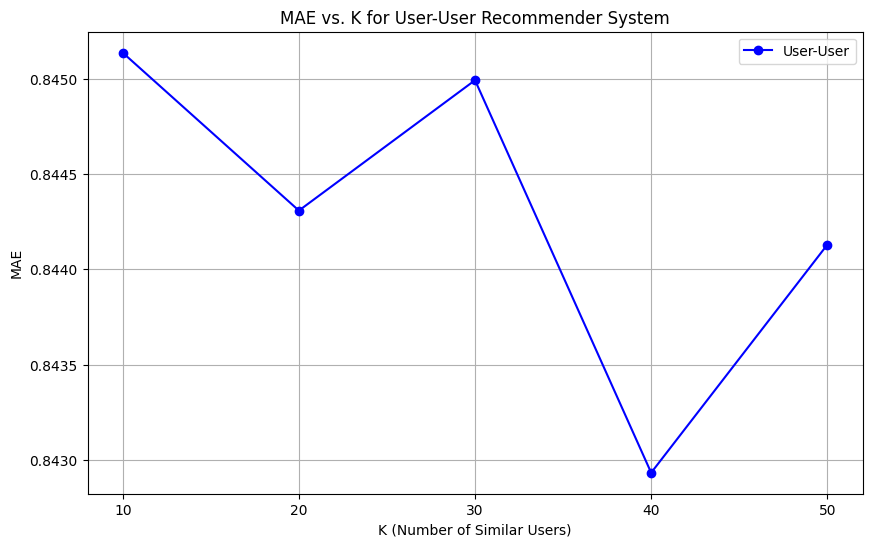

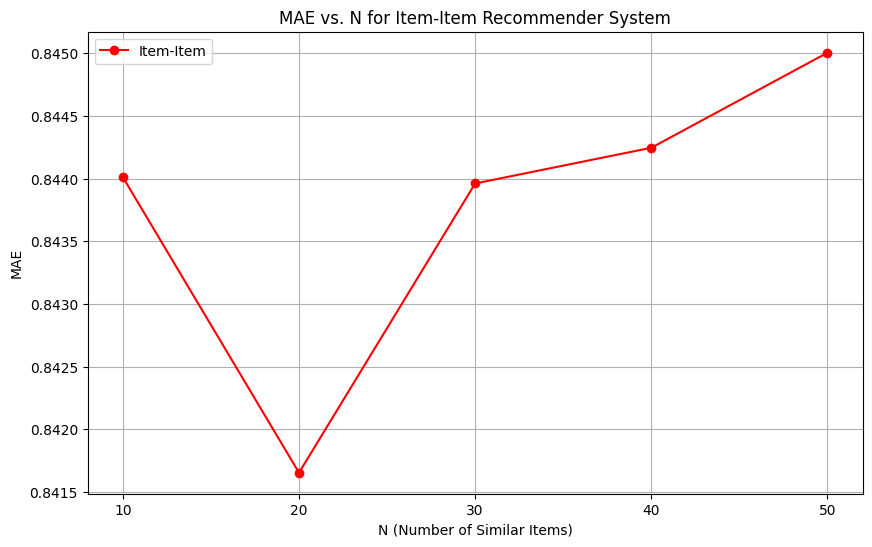

In [32]:
import matplotlib.pyplot as plt

# Extract K values and MAE results for user-user recommender system
K_values_user_user = list(MAE_results.keys())
MAE_values_user_user = list(MAE_results.values())

# Extract N values and MAE results for item-item recommender system
N_values_item_item = list(MAE_results_item_item.keys())
MAE_values_item_item = list(MAE_results_item_item.values())

# Plot MAE against K for user-user recommender system
plt.figure(figsize=(10, 6))
plt.plot(K_values_user_user, MAE_values_user_user, marker='o', color='b', label='User-User')
plt.title('MAE vs. K for User-User Recommender System')
plt.xlabel('K (Number of Similar Users)')
plt.ylabel('MAE')
plt.xticks(K_values_user_user)
plt.grid(True)
plt.legend()
plt.show()

# Plot MAE against N for item-item recommender system
plt.figure(figsize=(10, 6))
plt.plot(N_values_item_item, MAE_values_item_item, marker='o', color='r', label='Item-Item')
plt.title('MAE vs. N for Item-Item Recommender System')
plt.xlabel('N (Number of Similar Items)')
plt.ylabel('MAE')
plt.xticks(N_values_item_item)
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load MAE results for user-user recommender system from CSV
mae_results_users = pd.read_csv('/kaggle/input/mae-results/mae_results_users.csv')

# Load MAE results for item-item recommender system from CSV
mae_results_items = pd.read_csv('/kaggle/input/mae-results/mae_results_items.csv')

# Extract K values and MAE results for user-user recommender system
K_values_user_user = mae_results_users['K'].tolist()
MAE_values_user_user = mae_results_users['MAE'].tolist()

# Extract N values and MAE results for item-item recommender system
N_values_item_item = mae_results_items['K'].tolist()
MAE_values_item_item = mae_results_items['MAE'].tolist()

# Plot MAE against K for user-user recommender system
plt.figure(figsize=(10, 6))
plt.plot(K_values_user_user, MAE_values_user_user, marker='o', color='b', label='User-User')
plt.title('MAE vs. K for User-User Recommender System')
plt.xlabel('K (Number of Similar Users)')
plt.ylabel('MAE')
plt.xticks(K_values_user_user)
plt.grid(True)
plt.legend()
plt.show()

# Plot MAE against N for item-item recommender system
plt.figure(figsize=(10, 6))
plt.plot(N_values_item_item, MAE_values_item_item, marker='o', color='r', label='Item-Item')
plt.title('MAE vs. N for Item-Item Recommender System')
plt.xlabel('N (Number of Similar Items)')
plt.ylabel('MAE')
plt.xticks(N_values_item_item)
plt.grid(True)
plt.legend()
plt.show()

In [34]:
# Sum up the ratings for each product
product_sum_ratings = matrix.groupby('asin')['overall'].sum()

# Sort the products based on sum ratings in descending order
top_10_products = product_sum_ratings.sort_values(ascending=False).head(10)

# Print the top 10 products by User Sum Ratings
print("Top 10 Products by User Sum Ratings:")
print(top_10_products)

Top 10 Products by User Sum Ratings:
asin
B00LP6CFEC    90.0
B00STP86CW    80.0
B015R7AFVE    71.0
B00O2Y2MZG    66.0
B01A7G35S0    65.0
B00001WRSJ    65.0
B019C1MBWW    63.0
B00Q2VPI8A    63.0
B00UZ3LGKK    58.0
B0132YHU0I    56.0
Name: overall, dtype: float64
